# Neighborhoods

In [1]:
# Load packages
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import fiona


import geopandas

from shapely.geometry import shape, Point, Polygon, MultiPolygon

import json
import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load GeoJSON file of LA County boundaries
with open('los-angeles-county-2012.geojson', 'r') as f:
    js = json.load(f)

In [3]:
# load geometry
la_county = js['geometry']
la_county

{'type': 'MultiPolygon',
 'coordinates': [[[[-118.94484971412791, 34.04565678182138],
    [-118.943281, 34.057703],
    [-118.942499, 34.062421],
    [-118.94098, 34.074746],
    [-118.940801, 34.074967],
    [-118.788889, 34.168214],
    [-118.723374, 34.167861],
    [-118.711674, 34.168517],
    [-118.705066, 34.168597],
    [-118.668152, 34.168195],
    [-118.668176, 34.189867],
    [-118.667736, 34.210091],
    [-118.667867, 34.229171],
    [-118.667696, 34.23387],
    [-118.667713, 34.240404],
    [-118.632495, 34.240426],
    [-118.632649, 34.248387],
    [-118.632548, 34.263429],
    [-118.636789, 34.291804],
    [-118.741904, 34.5058],
    [-118.746156, 34.514056],
    [-118.77583, 34.574562],
    [-118.800396, 34.623881],
    [-118.800225, 34.623769],
    [-118.815868, 34.655414],
    [-118.886824, 34.801876],
    [-118.887362, 34.801898],
    [-118.894474, 34.817972],
    [-118.889341, 34.817663],
    [-118.884388, 34.817651],
    [-118.883169, 34.817928],
    [-118.881729, 3

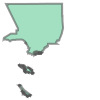

In [4]:
shape(la_county)

In [5]:
# load GeoJSON file containing neighborhood boundaries
with open('la-county-neighborhoods-current.geojson', 'r') as f:
    js = json.load(f)

In [6]:
# create dictionary of geometries of neighborhoods

hood_dict = {}
for feature in js['features']:
    k = feature['properties']['name']
    v = feature['geometry']
    hood_dict[k] = v

In [7]:
hood_dict.keys()

dict_keys(['Acton', 'Adams-Normandie', 'Agoura Hills', 'Agua Dulce', 'Alhambra', 'Alondra Park', 'Altadena', 'Angeles Crest', 'Arcadia', 'Arleta', 'Arlington Heights', 'Artesia', 'Athens', 'Atwater Village', 'Avalon', 'Avocado Heights', 'Azusa', 'Baldwin Hills/Crenshaw', 'Baldwin Park', 'Bel-Air', 'Bellflower', 'Bell Gardens', 'Bell', 'Beverly Crest', 'Beverly Grove', 'Beverly Hills', 'Beverlywood', 'Boyle Heights', 'Bradbury', 'Brentwood', 'Broadway-Manchester', 'Burbank', 'Calabasas', 'Canoga Park', 'Carson', 'Carthay', 'Castaic Canyons', 'Castaic', 'Central-Alameda', 'Century City', 'Cerritos', 'Charter Oak', 'Chatsworth', 'Chatsworth Reservoir', 'Chesterfield Square', 'Cheviot Hills', 'Chinatown', 'Citrus', 'Claremont', 'Commerce', 'Compton', 'Covina', 'Cudahy', 'Culver City', 'Cypress Park', 'Del Aire', 'Del Rey', 'Desert View Highlands', 'Diamond Bar', 'Downey', 'Downtown', 'Duarte', 'Eagle Rock', 'East Compton', 'East Hollywood', 'East La Mirada', 'East Los Angeles', 'East Pasad

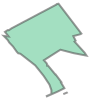

In [8]:
# note we can call shape object for any entry
shape(hood_dict['Venice'])

In [9]:
venice = (shape(hood_dict['Venice']))
type(venice)

shapely.geometry.multipolygon.MultiPolygon

In [10]:
# bounds attribute has (minlng, minlat, maxlng, maxlat)
venice.bounds

(-118.48396646263481,
 33.96266701475156,
 -118.44172493157204,
 34.00987941955189)

In [11]:
# we can determine if a (lng, lat) is within a given neighborhood ***NOTE ORDER OF COMPONENTS

VENICE_CENTER = (-118.4695, 33.9850)
point = Point(VENICE_CENTER)
venice.contains(point)

True

In [12]:
# alternatively,
point.within(venice)

True

In [13]:
# define a function to return neighborhood given (lat, lng)

def get_hood(lat, lng):
    point = Point(lng, lat)
    if point.within(shape(la_county)):
        for hood in hood_dict.keys():
            if shape(hood_dict[hood]).contains(point):
                return hood
    elif point.within(shape(la_county)) == FALSE:
        raise Exception('Point not in LA County')
    else:
        return 'Neighborhood not Found'

In [14]:
lat = 33.9850
lng = -118.4695
get_hood(lat, lng)


'Venice'

In [15]:
# load la open data crime 2010 to present dataframe
laod_df = pd.read_msgpack('LAOD_crime_2010_pres_df.msg')

In [16]:
laod_df.head()

,DR_NO,Date Rptd,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
date_time,,,,,,,,,,,,,,,,,,,,,
2010-02-20 13:50:00,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,...,AA,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695
2010-09-12 00:45:00,11401303,09/13/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,...,IC,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962
2010-08-09 15:15:00,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,...,IC,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524
2010-01-05 01:50:00,90631215,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,...,IC,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295
2010-01-02 21:00:00,100100501,01/03/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,...,IC,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488


In [17]:
# get neighborhoods for each crime
laod_hoods = []
total = 0
errors = 0
for lat, lng in tqdm(zip(laod_df['LAT'], laod_df['LON'])):
    try:
        nbhd = get_hood(lat, lng)
        laod_hoods.append(nbhd)
    except:
        errors += 1
        laod_hoods.append(np.NaN)
    total += 1
print(f'Finished with {errors} errors.\n{total} total records.')
        


Finished with 1169 errors.
2002224 total records.


In [18]:
pd.Series(laod_hoods, index=laod_df.index).to_msgpack('laod_hoods.msg')

In [19]:
laod_hoods[:5]

['Florence', 'Westchester', 'Central-Alameda', 'Hollywood', 'Downtown']

In [20]:
len(laod_hoods) == len(laod_df)

True

In [21]:
test_df = pd.read_msgpack('laod_hoods.msg')

In [22]:
test_df.head()

date_time
2010-02-20 13:50:00           Florence
2010-09-12 00:45:00        Westchester
2010-08-09 15:15:00    Central-Alameda
2010-01-05 01:50:00          Hollywood
2010-01-02 21:00:00           Downtown
dtype: object

In [24]:
test_df[test_df.isna()]

date_time
2010-03-23 01:25:00    None
2010-02-13 09:00:00    None
2010-02-20 08:58:00    None
2010-03-06 09:00:00    None
2010-03-12 09:45:00    None
2010-03-13 09:00:00    None
2010-03-20 09:00:00    None
2010-09-28 06:45:00    None
2010-11-18 21:00:00    None
2010-12-09 12:50:00    None
2010-10-23 03:00:00    None
2010-01-07 13:15:00    None
2010-02-23 17:00:00    None
2010-03-06 13:40:00    None
2010-03-10 15:00:00    None
2010-03-23 00:10:00    None
2010-06-02 13:45:00    None
2010-06-19 10:30:00    None
2010-07-19 03:45:00    None
2010-07-20 15:34:00    None
2010-07-30 22:45:00    None
2010-08-25 23:05:00    None
2010-08-30 09:00:00    None
2010-09-08 21:30:00    None
2010-10-12 13:00:00    None
2010-11-24 11:00:00    None
2010-12-23 20:40:00    None
2010-12-28 22:00:00    None
2010-11-23 13:00:00    None
2010-02-26 16:00:00    None
                       ... 
2019-03-21 09:15:00    None
2019-01-03 12:07:00    None
2019-04-10 12:00:00    None
2019-05-23 18:00:00    None
2019-07-03

In [25]:
import pickle

In [26]:
pickle.dump(laod_hoods, open('laod_hoods_list.p', 'wb'))

In [27]:
type(test_df)

pandas.core.series.Series

In [30]:
test_df.rename('neighborhood')

date_time
2010-02-20 13:50:00               Florence
2010-09-12 00:45:00            Westchester
2010-08-09 15:15:00        Central-Alameda
2010-01-05 01:50:00              Hollywood
2010-01-02 21:00:00               Downtown
2010-01-04 16:50:00               Downtown
2010-01-07 20:05:00               Downtown
2010-01-08 21:00:00               Downtown
2010-01-09 02:30:00               Downtown
2010-01-06 21:00:00               Downtown
2010-01-14 14:45:00              Chinatown
2010-01-14 20:00:00               Downtown
2010-01-15 02:45:00               Downtown
2010-01-15 17:45:00               Downtown
2010-01-15 20:30:00               Downtown
2010-01-16 17:35:00               Downtown
2010-01-23 12:25:00               Downtown
2010-01-23 11:00:00               Downtown
2010-01-23 20:00:00               Downtown
2010-01-26 18:20:00               Downtown
2010-01-28 23:45:00               Downtown
2010-01-29 16:30:00               Downtown
2010-01-31 01:30:00               Downtown
2

In [32]:
laod_df['neighborhood'] = test_df

In [33]:
laod_df.head()

,DR_NO,Date Rptd,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,neighborhood
date_time,,,,,,,,,,,,,,,,,,,,,
2010-02-20 13:50:00,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,...,Adult Arrest,900.0,NaN,NaN,NaN,300 E GAGE AV,NaN,33.9825,-118.2695,Florence
2010-09-12 00:45:00,11401303,09/13/2010 12:00:00 AM,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,...,Invest Cont,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,Westchester
2010-08-09 15:15:00,70309629,08/09/2010 12:00:00 AM,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,...,Invest Cont,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,34.0224,-118.2524,Central-Alameda
2010-01-05 01:50:00,90631215,01/05/2010 12:00:00 AM,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,...,Invest Cont,900.0,998.0,NaN,NaN,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,Hollywood
2010-01-02 21:00:00,100100501,01/03/2010 12:00:00 AM,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,...,Invest Cont,122.0,NaN,NaN,NaN,8TH ST,SAN PEDRO ST,34.0387,-118.2488,Downtown


In [34]:
laod_df.to_msgpack('laod_df_with_hoods.msg')

In [41]:
laod_df[pd.isna(laod_df['neighborhood'])]

,DR_NO,Date Rptd,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,neighborhood
date_time,,,,,,,,,,,,,,,,,,,,,
2010-03-23 01:25:00,100100743,03/25/2010 12:00:00 AM,125,1,Central,192,1,310,BURGLARY,0344,...,Invest Cont,310.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-02-13 09:00:00,100106310,02/13/2010 12:00:00 AM,900,1,Central,192,2,900,VIOLATION OF COURT ORDER,1501,...,Invest Cont,900.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-02-20 08:58:00,100106691,02/20/2010 12:00:00 AM,858,1,Central,192,2,900,VIOLATION OF COURT ORDER,NaN,...,Invest Cont,900.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-03-06 09:00:00,100107364,03/06/2010 12:00:00 AM,900,1,Central,192,2,900,VIOLATION OF COURT ORDER,NaN,...,Invest Cont,900.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-03-12 09:45:00,100107635,03/12/2010 12:00:00 AM,945,1,Central,192,2,624,BATTERY - SIMPLE ASSAULT,0416 0917 1300 1402,...,Adult Other,624.0,998.0,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-03-13 09:00:00,100107685,03/13/2010 12:00:00 AM,900,1,Central,192,2,900,VIOLATION OF COURT ORDER,NaN,...,Invest Cont,900.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-03-20 09:00:00,100108089,03/20/2010 12:00:00 AM,900,1,Central,192,2,900,VIOLATION OF COURT ORDER,NaN,...,Invest Cont,900.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-09-28 06:45:00,100117796,09/29/2010 12:00:00 AM,645,1,Central,192,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0344,...,Invest Cont,420.0,NaN,NaN,NaN,200 W WASHINGTON BL,NaN,34.0320,-118.2667,None
2010-11-18 21:00:00,100120403,11/19/2010 12:00:00 AM,2100,1,Central,195,1,220,ATTEMPTED ROBBERY,0355 0416 0417 0429,...,Invest Cont,220.0,NaN,NaN,NaN,MAPLE,WASHINGTON,34.0296,-118.2614,None


In [40]:
Point((33.7978, -118.2870)).within(shape(la_county))

False

In [46]:
venice_df = laod_df[laod_df['neighborhood']=='Venice']

In [48]:
venice_homi_df = venice_df[venice_df['Crm Cd'] == 110]
venice_homi_df.head()

,DR_NO,Date Rptd,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,neighborhood
date_time,,,,,,,,,,,,,,,,,,,,,
2010-06-13 01:54:00,101414595,06/13/2010 12:00:00 AM,154,14,Pacific,1443,1,110,CRIMINAL HOMICIDE,0906 1501,...,Invest Cont,110.0,NaN,NaN,NaN,2400 LOUELLA AV,NaN,33.9962,-118.4482,Venice
2011-06-22 16:05:00,111418602,06/22/2011 12:00:00 AM,1605,14,Pacific,1416,1,110,CRIMINAL HOMICIDE,0371 0906 1100 1501,...,Adult Arrest,110.0,NaN,NaN,NaN,LAKE ST,PENMAR ST,34.0047,-118.4587,Venice
2011-07-06 15:55:00,111420327,07/08/2011 12:00:00 AM,1555,14,Pacific,1433,1,110,CRIMINAL HOMICIDE,0400 0416 1601,...,Adult Arrest,110.0,NaN,NaN,NaN,LINCOLN BL,SUPERBA,33.9964,-118.4575,Venice
2011-06-22 16:05:00,111418603,06/22/2011 12:00:00 AM,1605,14,Pacific,1416,1,110,CRIMINAL HOMICIDE,0371 0430 0906 1270 1501,...,Adult Arrest,110.0,NaN,NaN,NaN,LAKE ST,PENMAR ST,34.0047,-118.4587,Venice
2011-02-24 18:15:00,111407885,02/24/2011 12:00:00 AM,1815,14,Pacific,1412,1,110,CRIMINAL HOMICIDE,0411 0913 1401 1402,...,Adult Arrest,110.0,998.0,NaN,NaN,THORNTON,MAIN ST,33.9935,-118.4752,Venice


In [49]:
len(venice_homi_df)

17

In [51]:

LA_CENTER = [34.0522, -118.2437]
hood = 'Pacoima'
# create map
m = folium.Map(location=LA_CENTER)
locs = venice_homi_df[['LAT', 'LON']].values
for loc in locs:
    folium.Circle(
        radius=50,
        location=[loc[0], loc[1]],
       
        fill=True,
    ).add_to(m)
m